# Imports

In [115]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter, resample
from tensorflow.keras.layers import Input

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler,StandardScaler

from scipy.stats import pearsonr
import seaborn as sns

# Load Data

In [135]:
# Dataset ID
date_id = "20250319"
record_id = "300"
segment_length = 48

# Path to dataset folder
dataset_path = f"../../../datasets/xydataset/csv/s{date_id}/s{date_id}_{record_id}/{segment_length}"
#dataset_path = f"../../datasets/s{date_id}_{record_id}_resampled_48"

# Load CSVs
X_train = pd.read_csv(f"{dataset_path}/x_train.csv").values
X_test = pd.read_csv(f"{dataset_path}/x_test.csv").values
y_train = pd.read_csv(f"{dataset_path}/y_train.csv").values
y_test = pd.read_csv(f"{dataset_path}/y_test.csv").values

# Reshape X to (samples, timesteps, features) for LSTM
X_train = X_train.reshape(-1, segment_length, 1)
X_test = X_test.reshape(-1, segment_length, 1)

print("Loaded shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Loaded shapes:
X_train: (799, 48, 1)
y_train: (799, 1)
X_test: (199, 48, 1)
y_test: (199, 1)


# Plot Loaded Data (4 Subplots)

<IPython.core.display.Javascript object>


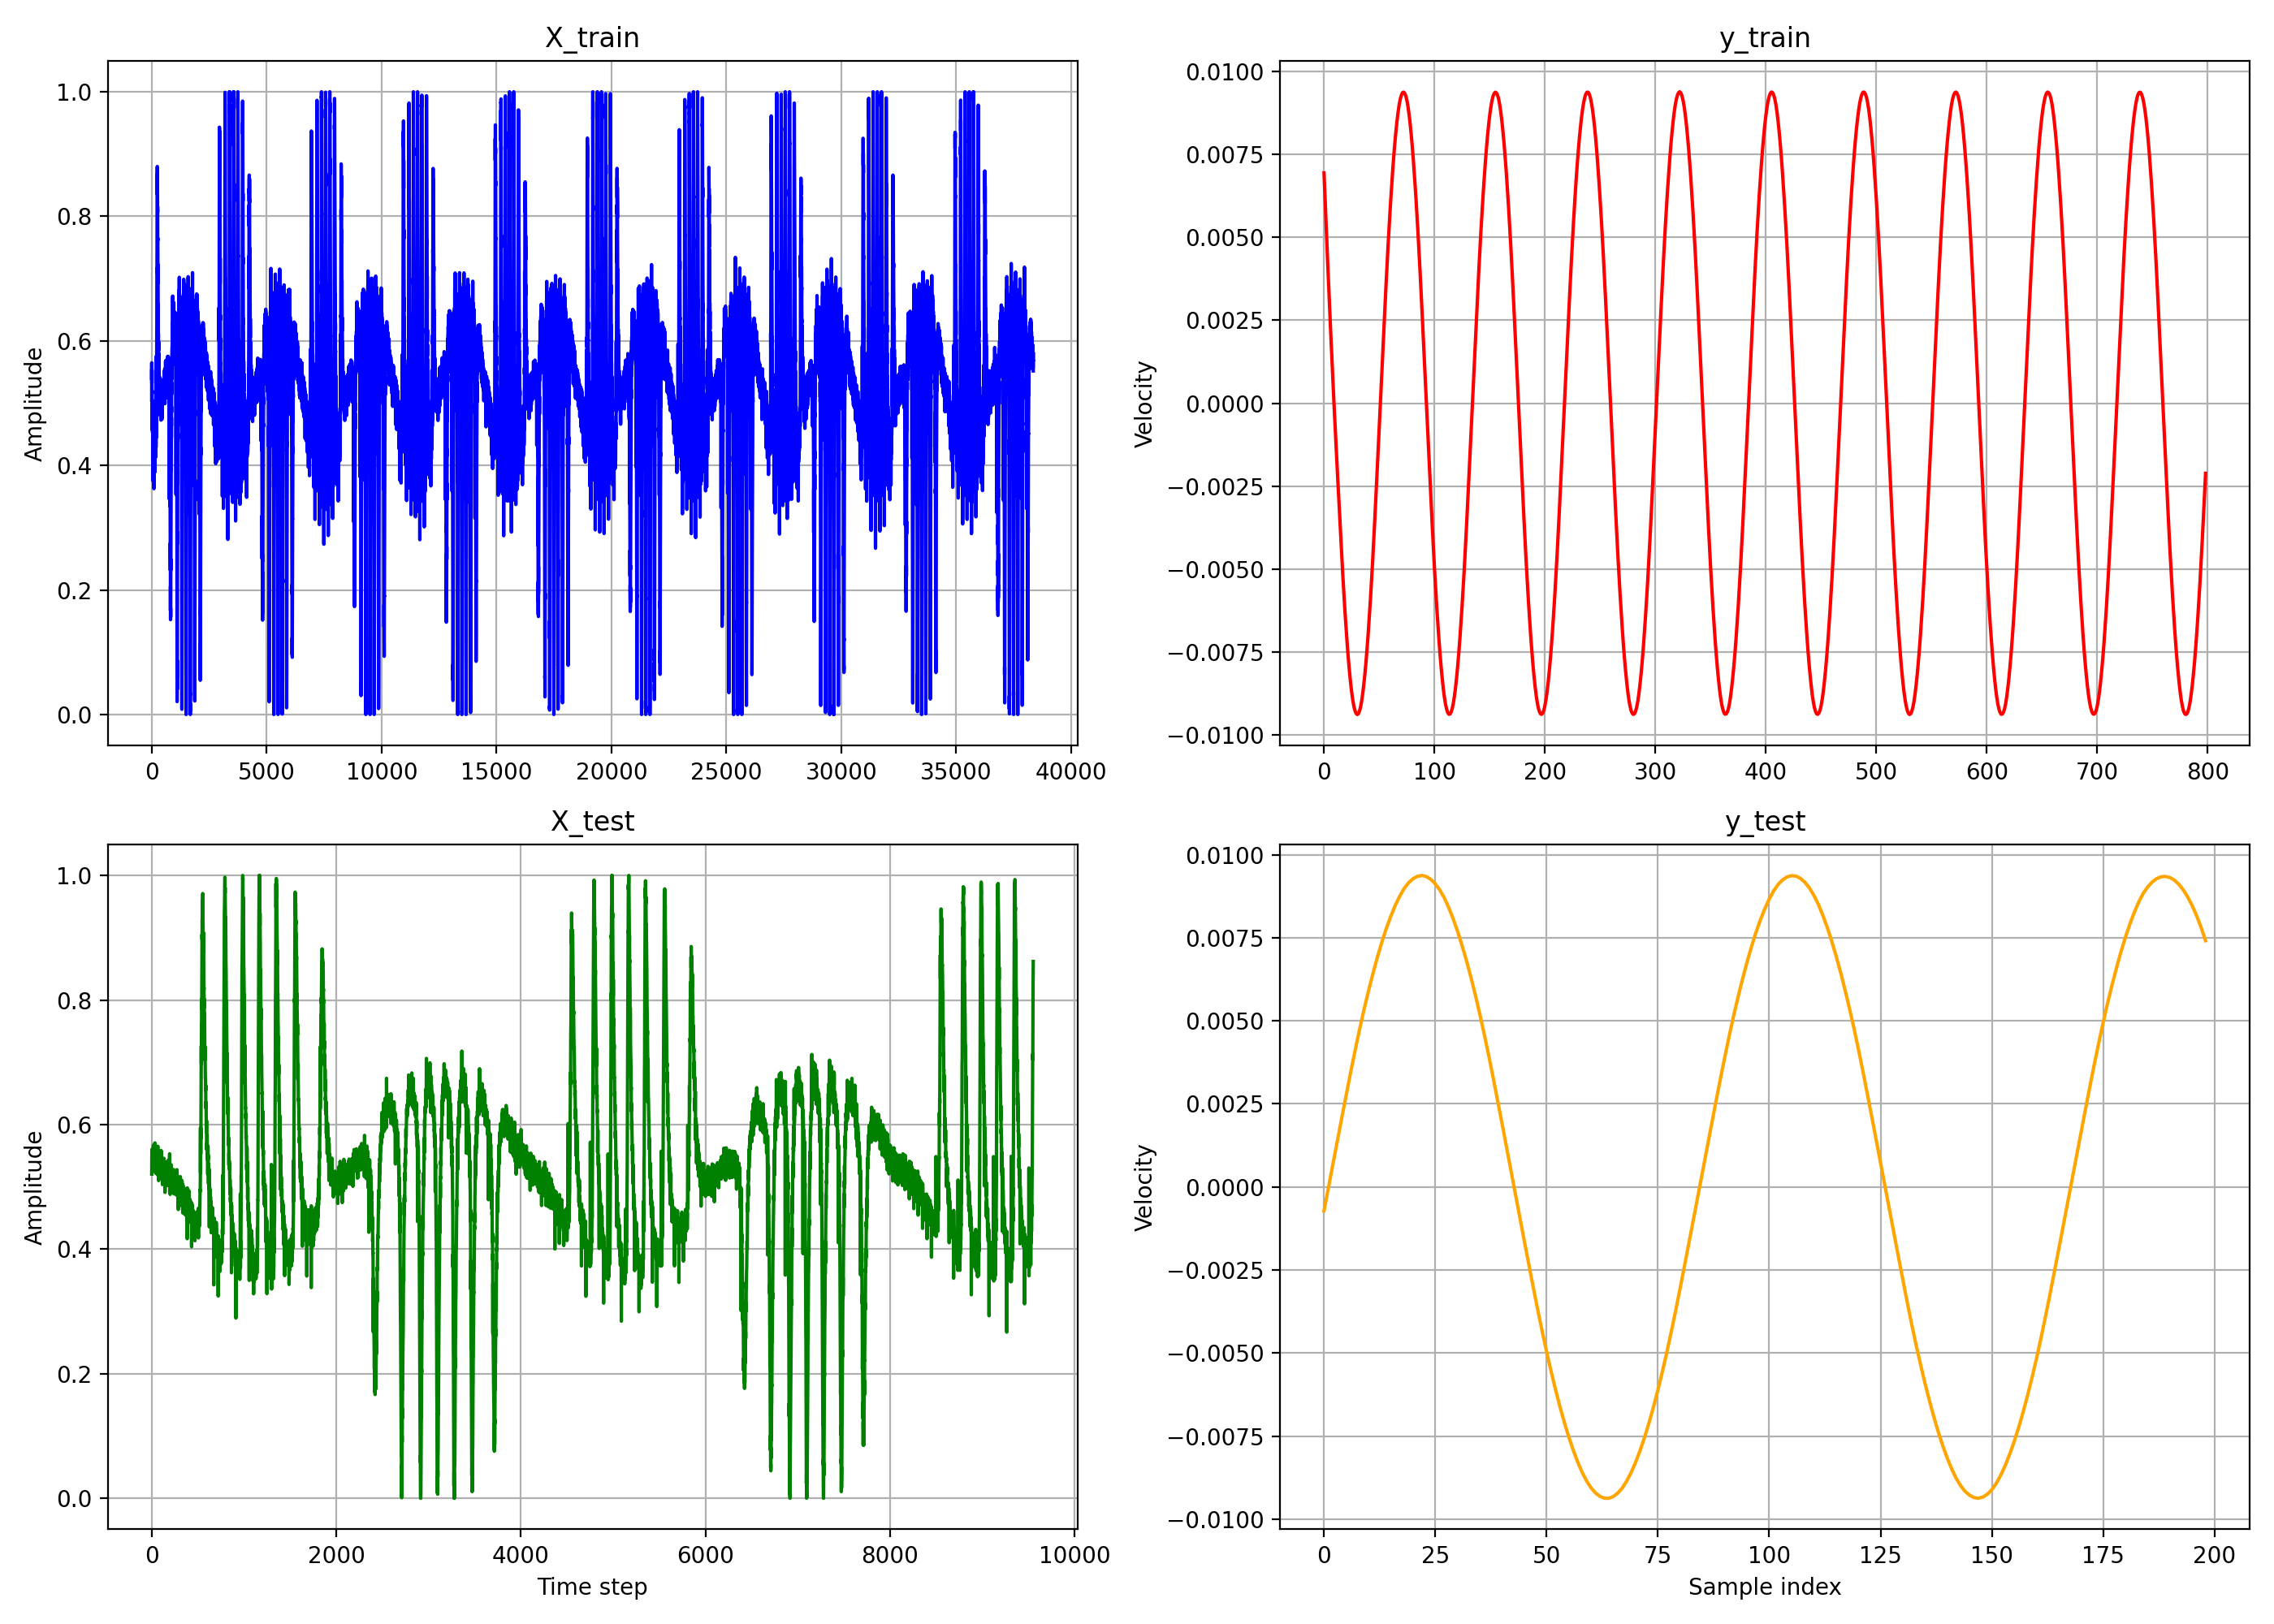

In [136]:
# Flatten for continuous plotting
X_train_cont = X_train.squeeze().flatten()
X_test_cont = X_test.squeeze().flatten()
y_train_cont = y_train.flatten()
y_test_cont = y_test.flatten()

# Create time axes
t_X_train = np.arange(len(X_train_cont))
t_X_test = np.arange(len(X_test_cont))
t_y_train = np.arange(len(y_train_cont))
t_y_test = np.arange(len(y_test_cont))

# Plot the data
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(t_X_train, X_train_cont, color='blue')
plt.title("X_train")
plt.ylabel("Amplitude")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(t_y_train, y_train_cont, color='red')
plt.title("y_train")
plt.ylabel("Velocity")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(t_X_test, X_test_cont, color='green')
plt.title("X_test")
plt.xlabel("Time step")
plt.ylabel("Amplitude")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(t_y_test, y_test_cont, color='orange')
plt.title("y_test")
plt.xlabel("Sample index")
plt.ylabel("Velocity")
plt.grid(True)

plt.tight_layout()
plt.show()

# Scale data

In [137]:
scaling_method = ""

# Choose scalers based on method
if scaling_method == "minmax_01":
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
elif scaling_method == "minmax_11":
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    scaler_y = MinMaxScaler(feature_range=(-1, 1))
else:  # Default to standard
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

# Apply scaling to X
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[1])).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[1])).reshape(X_test.shape)

# Apply scaling to y
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Plot scalled data

<IPython.core.display.Javascript object>


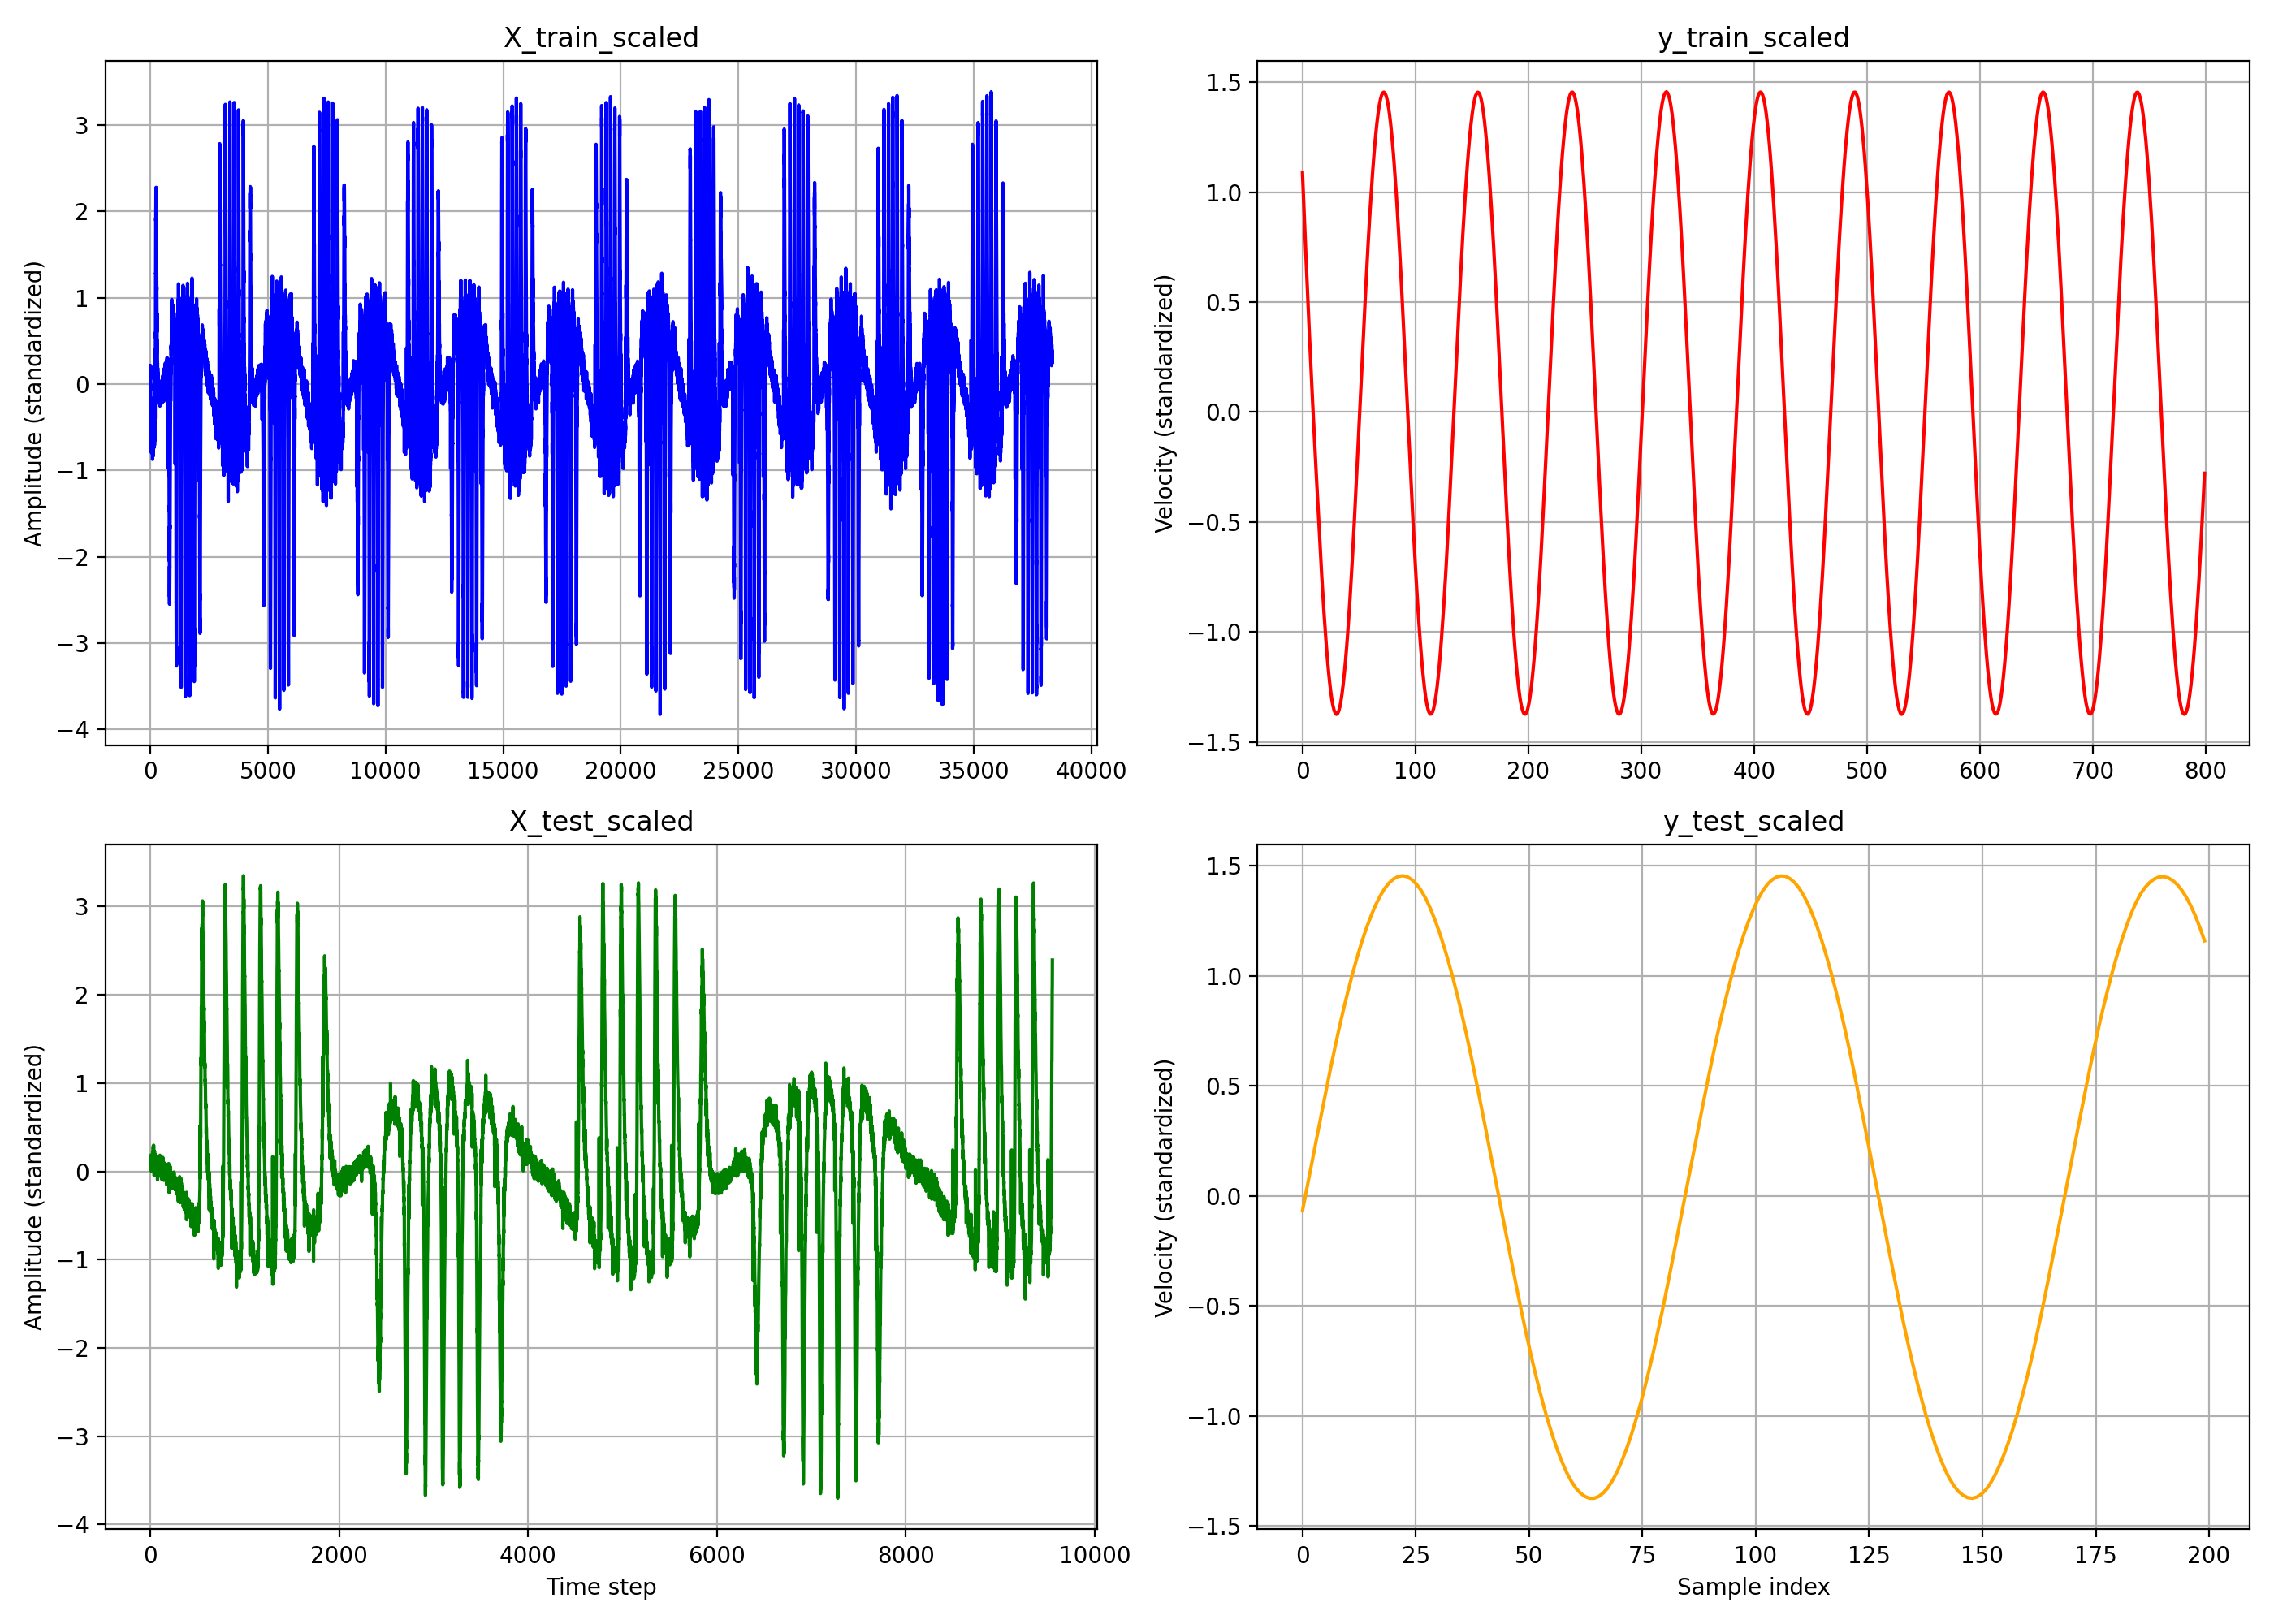

In [138]:
# Flatten the 3D inputs (X) for plotting
X_train_scaled_cont = X_train_scaled.reshape(-1)
X_test_scaled_cont = X_test_scaled.reshape(-1)
y_train_scaled_cont = y_train_scaled.flatten()
y_test_scaled_cont = y_test_scaled.flatten()

# Create time axes
t_X_train = np.linspace(0, len(X_train_scaled_cont), len(X_train_scaled_cont))
t_X_test = np.linspace(0, len(X_test_scaled_cont), len(X_test_scaled_cont))
t_y_train = np.linspace(0, len(y_train_scaled_cont), len(y_train_scaled_cont))
t_y_test = np.linspace(0, len(y_test_scaled_cont), len(y_test_scaled_cont))

# Plot
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(t_X_train, X_train_scaled_cont, color='blue')
plt.title("X_train_scaled")
plt.ylabel("Amplitude (standardized)")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(t_y_train, y_train_scaled_cont, color='red')
plt.title("y_train_scaled")
plt.ylabel("Velocity (standardized)")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(t_X_test, X_test_scaled_cont, color='green')
plt.title("X_test_scaled")
plt.xlabel("Time step")
plt.ylabel("Amplitude (standardized)")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(t_y_test, y_test_scaled_cont, color='orange')
plt.title("y_test_scaled")
plt.xlabel("Sample index")
plt.ylabel("Velocity (standardized)")
plt.grid(True)

plt.tight_layout()
plt.show()

# LSTM model

In [139]:
# Shape
segment_length = X_train.shape[1]
num_features = X_train.shape[2]

# Model
model = Sequential()
model.add(Input(shape=(segment_length, num_features)))
model.add(LSTM(16))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Summary
model.summary()

# Get the total number of parameters in the model
total_params = model.count_params()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,297 (5.07 KB)

 Trainable params: 1,297 (5.07 KB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [140]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
use_early_stop=True

if(use_early_stop):
    history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    validation_data=(X_test_scaled, y_test_scaled),
    batch_size=16,callbacks=[early_stop]
    )
else:
    history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    validation_data=(X_test_scaled, y_test_scaled),
    batch_size=16
    )

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9530 - mae: 0.8711 - val_loss: 0.8116 - val_mae: 0.7899
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7588 - mae: 0.7500 - val_loss: 0.5169 - val_mae: 0.5653
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5232 - mae: 0.5731 - val_loss: 0.4156 - val_mae: 0.4865
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4204 - mae: 0.4913 - val_loss: 0.3300 - val_mae: 0.4226
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3720 - mae: 0.4651 - val_loss: 0.2912 - val_mae: 0.3905
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2592 - mae: 0.3663 - val_loss: 0.1547 - val_mae: 0.2900
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1576 - mae: 0.2752 - val_loss: 0.1954 - val_mae: 0.2868
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1496 - mae: 0.2765 - val_loss: 0.1307 - val_mae: 0.2613
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.116

Epoch 55/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0381 - mae: 0.1521 - val_loss: 0.0325 - val_mae: 0.1405
Epoch 56/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0445 - mae: 0.1635 - val_loss: 0.0336 - val_mae: 0.1413
Epoch 57/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0380 - mae: 0.1515 - val_loss: 0.0343 - val_mae: 0.1410
Epoch 58/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0449 - mae: 0.1657 - val_loss: 0.0344 - val_mae: 0.1443
Epoch 59/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0396 - mae: 0.1538 - val_loss: 0.0304 - val_mae: 0.1392
Epoch 60/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0316 - mae: 0.1397 - val_loss: 0.0295 - val_mae: 0.1372
Epoch 61/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0380 - mae: 0.1507 - val_loss: 0.0297 - val_mae: 0.1359
Epoch 62/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1355 - mae: 0.1911 - val_loss: 0.4457 - val_mae: 0.4905
Epoch 63/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - lo

# Plotting Loss and MAE

<IPython.core.display.Javascript object>


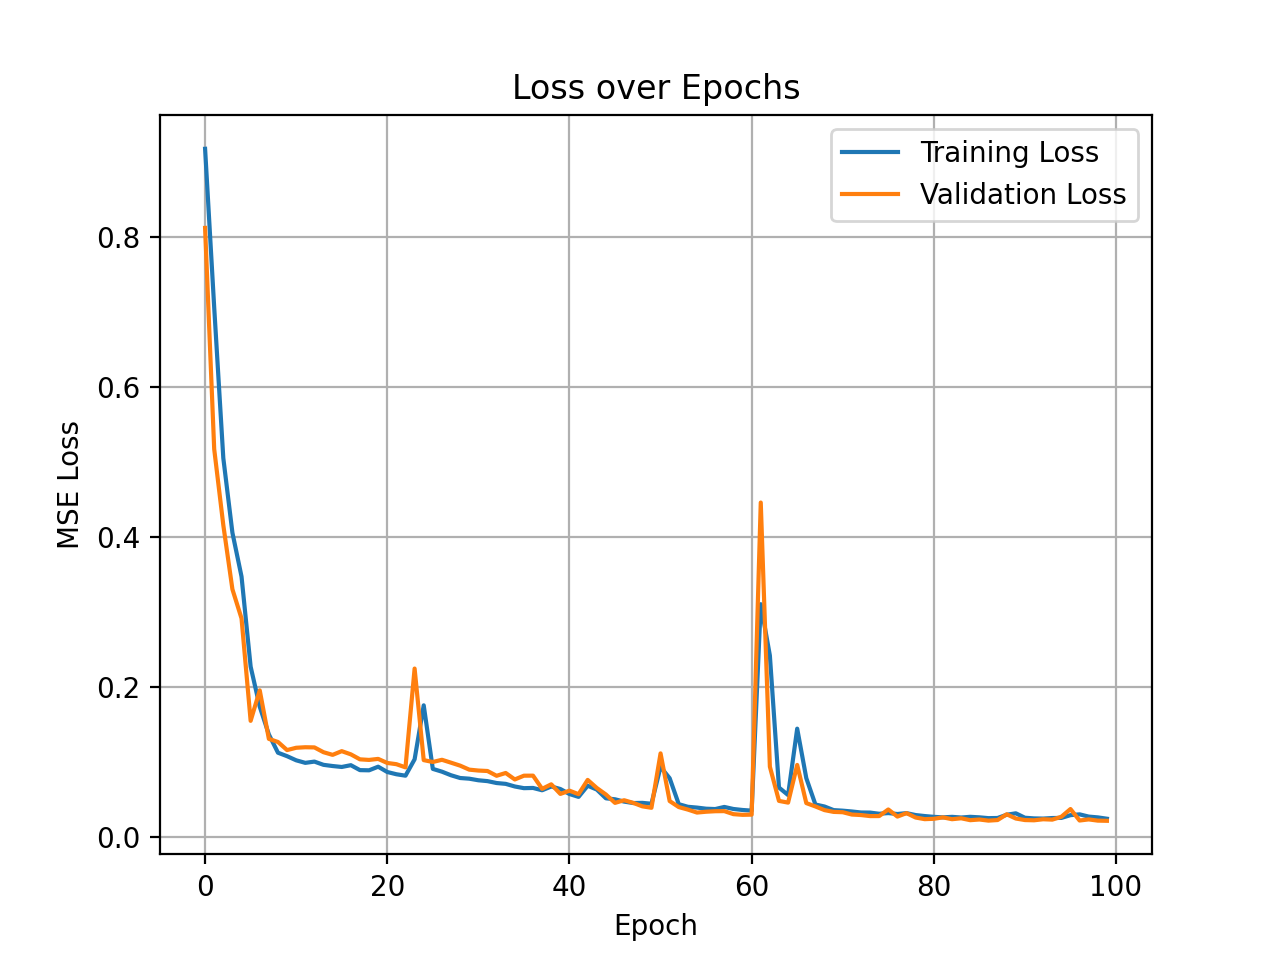

<IPython.core.display.Javascript object>


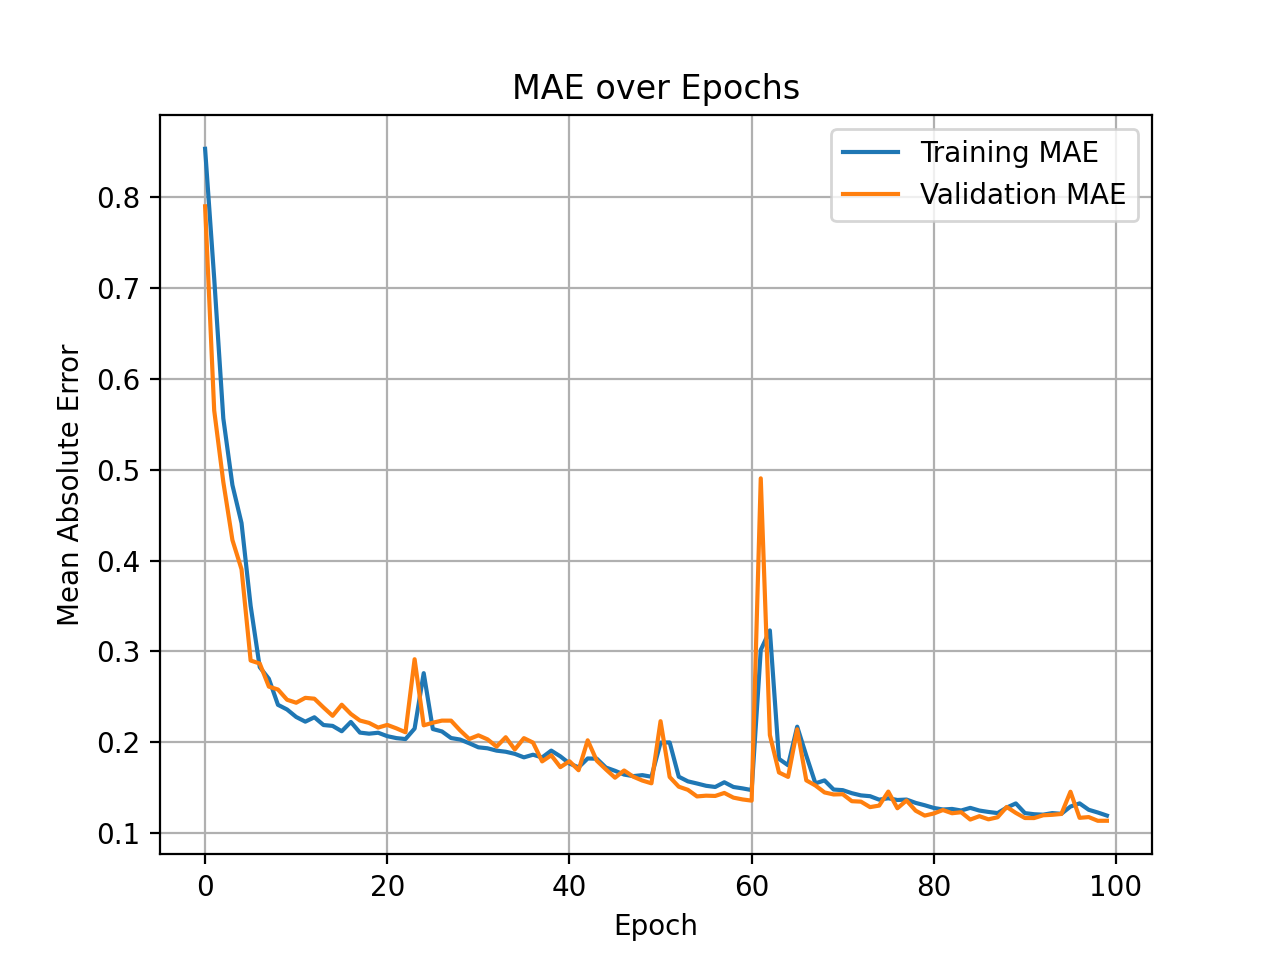

In [141]:
# Plot Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot MAE
plt.figure()
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model

In [142]:
# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=1)
print(f"\nTest Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0205 - mae: 0.1121 

Test Loss (MSE): 0.0215
Test MAE: 0.1137


# Predict and Inverse-transform to original scale

In [124]:
# Predict on test data
y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform to get back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [125]:
# Pearson correlation coefficient
r_value, _ = pearsonr(y_true.flatten(), y_pred.flatten())
print(f"Pearson correlation coefficient (r): {r_value:.4f}")

Pearson correlation coefficient (r): 0.9735


# Plot prediction vs Ground Truth

<IPython.core.display.Javascript object>


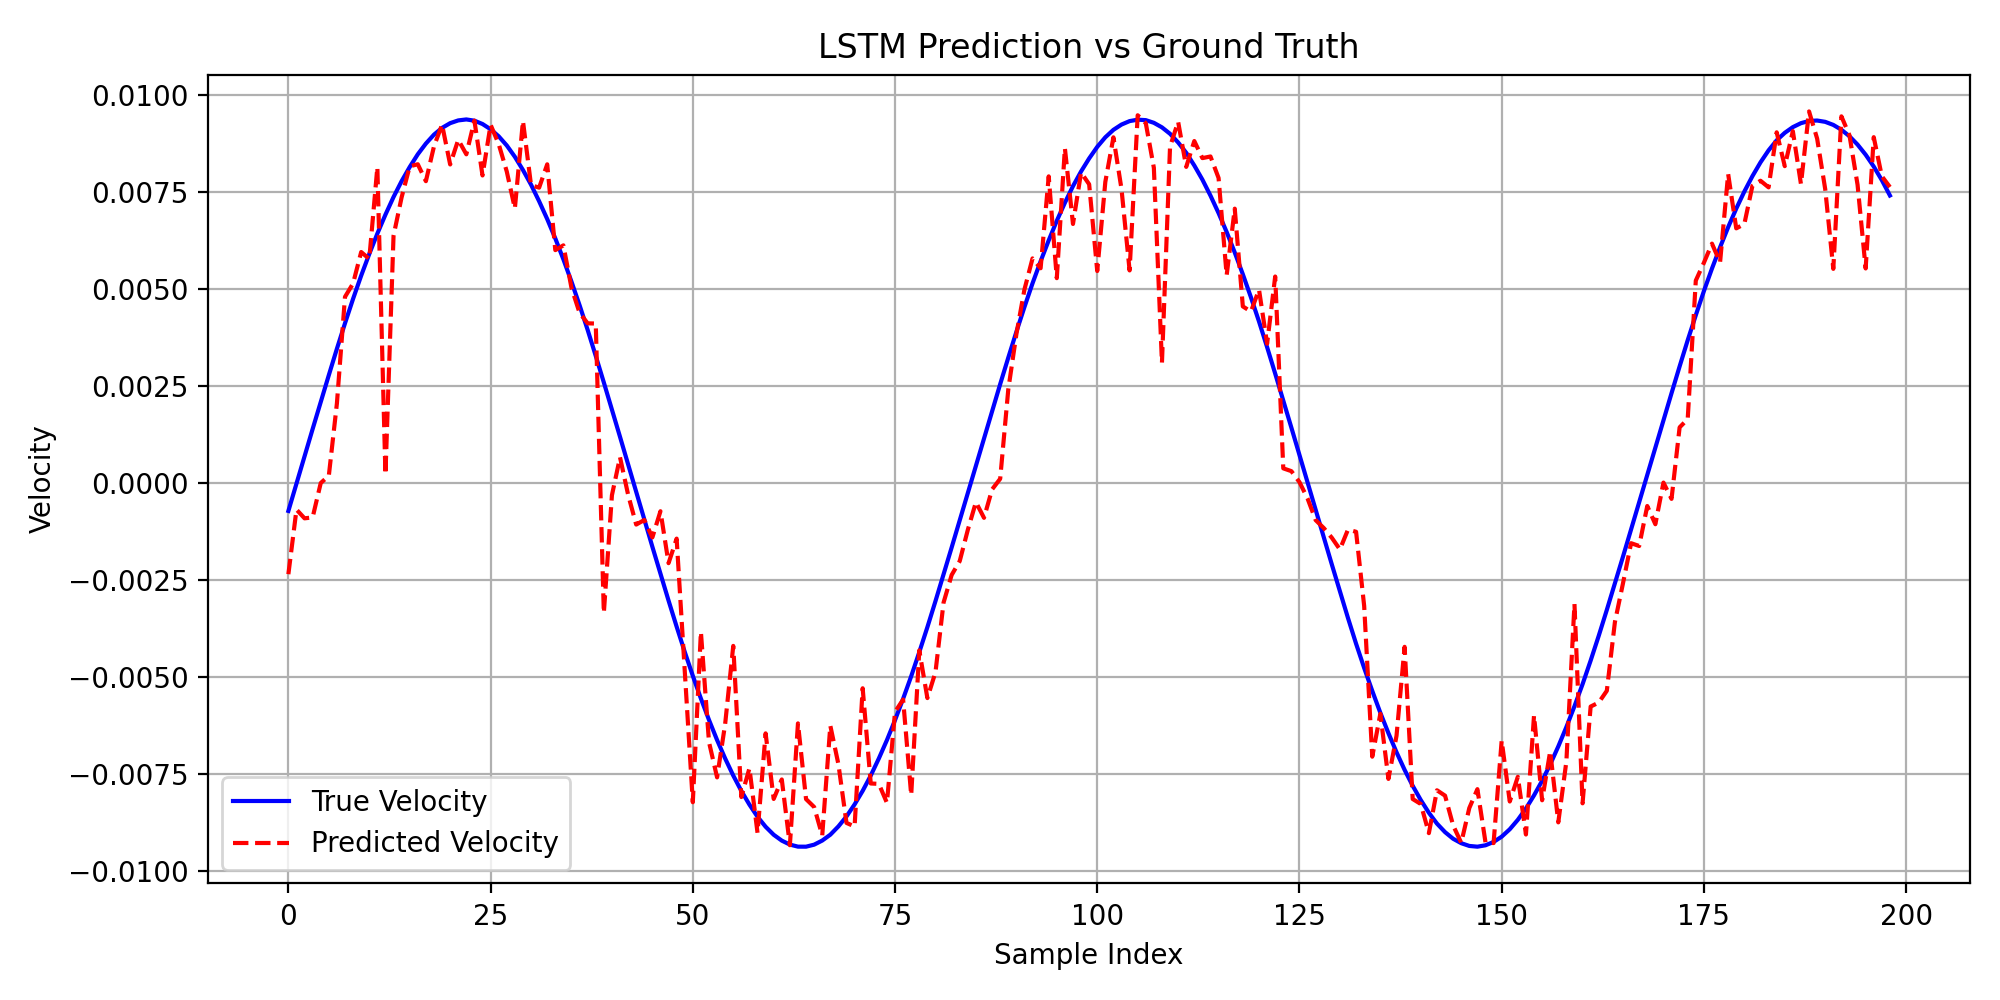

In [126]:
plt.figure(figsize=(10, 5))
plt.plot(y_true, label="True Velocity", color='blue')
plt.plot(y_pred, label="Predicted Velocity", color='red', linestyle='--')
plt.xlabel("Sample Index")
plt.ylabel("Velocity")
plt.title("LSTM Prediction vs Ground Truth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Regression Plot

<IPython.core.display.Javascript object>


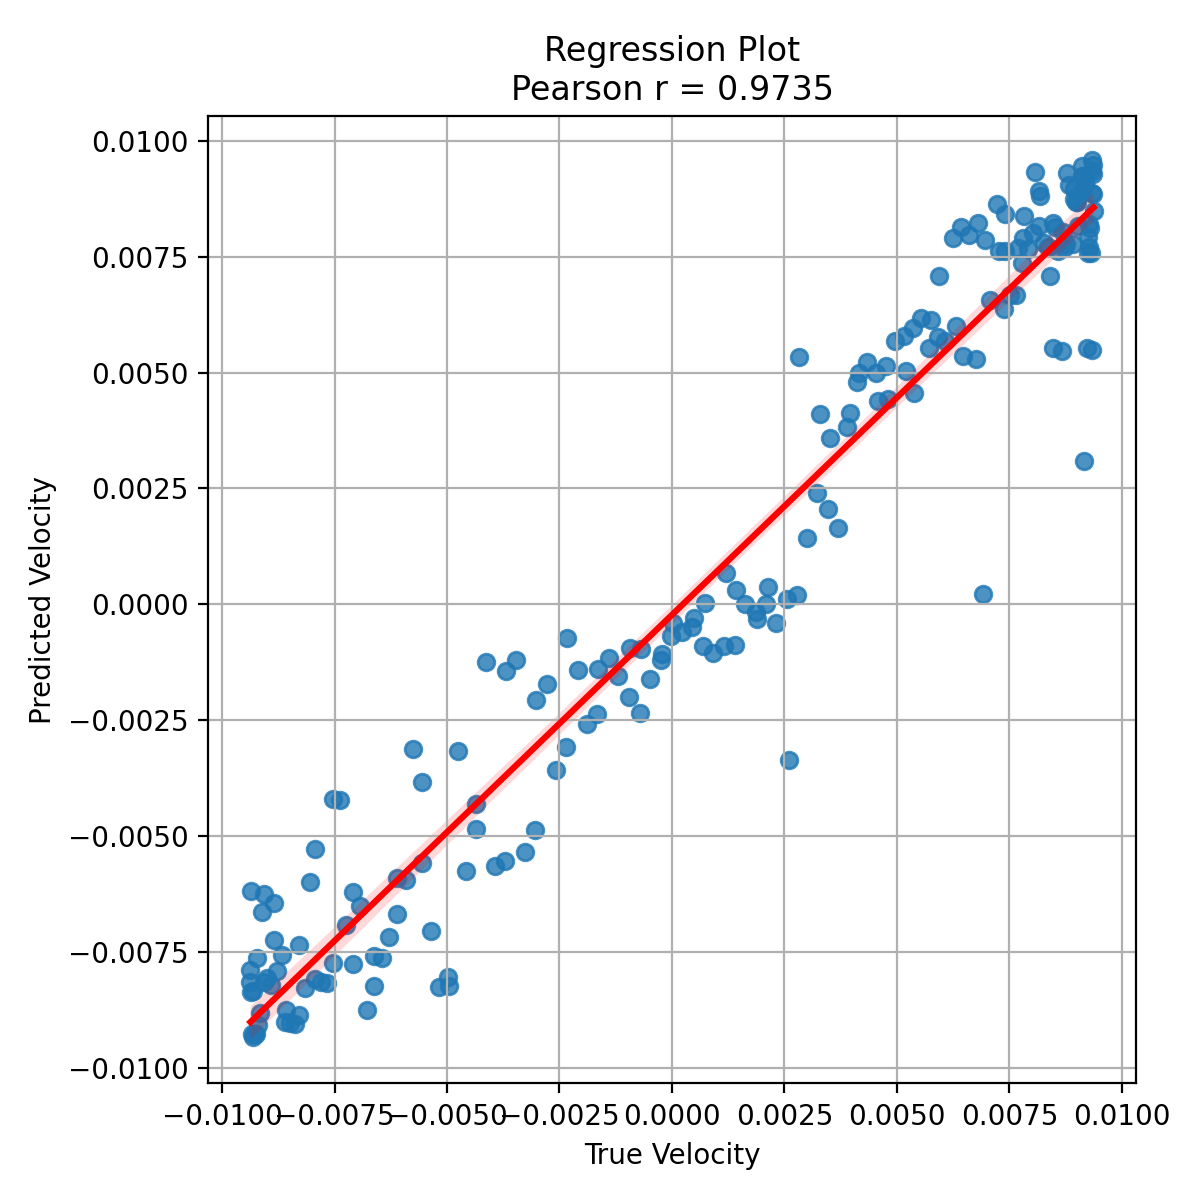

In [127]:
plt.figure(figsize=(6, 6))
sns.regplot(x=y_true.flatten(), y=y_pred.flatten(), line_kws={"color": "red"})
plt.xlabel("True Velocity")
plt.ylabel("Predicted Velocity")
plt.title(f"Regression Plot\nPearson r = {r_value:.4f}")
plt.grid(True)
plt.tight_layout()
plt.show()


# Save Model

In [128]:
save_dir = f"saved_models/{segment_length}"
os.makedirs(save_dir, exist_ok=True)

# Save model with total parameters in the filename
model.save(os.path.join(save_dir, f"{r_value}pearson_{total_params}params.h5"), include_optimizer=False)
print(f"Model saved")

Model saved
